In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats


import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing dataset

train = pd.read_csv('zillow/train.csv')

#Test portion of the dataset for evaluation without the target label

test = pd.read_csv('zillow/test.csv')

In [3]:
#Removing Outliers
#train = train[train.GrLivArea < 4500]

In [4]:
print("Shape before removal ", train.shape)
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>3100) & (train['SalePrice']<300000)].index, inplace=True)
print("Shape after removal ", train.shape)

Shape before removal  (1460, 81)
Shape after removal  (1454, 81)


In [5]:
#Fixing typo

df_train = train.replace({"Exterior2nd":{"CmentBd":"CemntBd"}})

#Saving Id for further refference
Id = df_train['Id']

#Dropping Id from dataset
df_train.drop('Id', axis=1, inplace=True)  #For feature engeneering

# Data Cleaning And Preparation

In [6]:
#Saving SalePrice
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice'].reset_index(drop=True)

In [7]:
#Concatenate train and test 
df = pd.concat([train, test]).reset_index(drop=True)

In [8]:
#Remove SalePrice from df
df = df.drop(['SalePrice'], axis=1)

In [9]:
#Checking shape of concatenated dataset
df.shape

(2913, 80)

In [10]:
#Some helpers functions
#Function that split dataset to numerical and textual and check for missing values

def missing_numcat(data, categorical=True):
    """This function splits dataset into numerical and textual portion of the data and make dataframe with missing values"""
    if categorical:
        categorical_text = data.select_dtypes(include='object')
        categorical_cnt = categorical_text.count()
        cat_with_missing = categorical_cnt[categorical_cnt.values < len(data)]
        cat_percent =  (len(data) - cat_with_missing.values) / len(data)
        missing_categorical =pd.DataFrame({'values': cat_with_missing,
                                  'NaN vals':(len(data) - cat_with_missing.values), '(%) NaN':cat_percent})
        return missing_categorical
    else:
        numerical_data = data._get_numeric_data()
        numerical_cnt = numerical_data.count()
        num_with_missing = numerical_cnt[numerical_cnt.values < len(data)]
        num_percent =  (len(data) - num_with_missing.values) / len(data)
        missing_numerical =pd.DataFrame({'values': num_with_missing,
                                          'NaN vals':(len(data) - num_with_missing.values), '(%) NaN':num_percent}) 
        return missing_numerical
    
    
    
#Function that fixes skewnes
from scipy.stats import skew
def fix_skew(c):
    """This function takes only numeric portion of the dataset and fix skewnes"""
    numeric_feats = c.dtypes[c.dtypes != "object"].index

    skewed_feats = c[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index

    c[skewed_feats] = np.log1p(c[skewed_feats])
    return c 

In [11]:
#In Compliance with the documentation these cathegorical features should have No feature as string instead nan values
df['Alley'] = df['Alley'].fillna('No Alley Access')
df['BsmtQual'] = df['BsmtQual'].fillna('No Basement')
df['BsmtCond'] = df['BsmtCond'].fillna('No Basement')
df['BsmtExposure'] = df['BsmtExposure'].fillna('No Basement')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('No Basement')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('No Basement')
df['FireplaceQu'] = df['FireplaceQu'].fillna('No Fireplace')
df['GarageType']  = df['GarageType'].fillna('No Garage')
df['GarageFinish'] = df['GarageFinish'].fillna('No Garage')
df['GarageQual'] = df['GarageQual'].fillna('No Garage')
df['GarageCond'] = df['GarageCond'].fillna('No Garage')
df['PoolQC'] = df['PoolQC'].fillna('No Pool')
df['Fence'] = df['Fence'].fillna('No Fence')
df['MiscFeature'] = df['MiscFeature'].fillna('No msc feature')
df['MasVnrType'] = df['MasVnrType'].fillna('No Veneer')

In [12]:
missing_numcat(df, categorical=True)

,values,NaN vals,(%) NaN
Electrical,2912,1,0.000343
Exterior1st,2912,1,0.000343
Exterior2nd,2912,1,0.000343
Functional,2911,2,0.000687
KitchenQual,2912,1,0.000343
MSZoning,2909,4,0.001373
SaleType,2912,1,0.000343
Utilities,2911,2,0.000687


In [13]:
#Fill nans with categorical features
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)
df['Functional'] = df['Functional'].fillna('Typ') 
df['Electrical'] = df['Electrical'].fillna("SBrkr") 
df['KitchenQual'] = df['KitchenQual'].fillna("TA") 
df["PoolQC"] = df["PoolQC"].fillna("No Pool")
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0]) 
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
#MSzoning
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])

In [14]:
missing_numcat(df, categorical=True)  #No more missing value in categorical features

,values,NaN vals,(%) NaN


In [15]:
print(missing_numcat(df, categorical=False))

              values  NaN vals   (%) NaN
BsmtFinSF1      2912         1  0.000343
BsmtFinSF2      2912         1  0.000343
BsmtFullBath    2911         2  0.000687
BsmtHalfBath    2911         2  0.000687
BsmtUnfSF       2912         1  0.000343
GarageArea      2912         1  0.000343
GarageCars      2912         1  0.000343
GarageYrBlt     2755       158  0.054240
LotFrontage     2428       485  0.166495
MasVnrArea      2890        23  0.007896
TotalBsmtSF     2912         1  0.000343


In [16]:
#Garage
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
df['GarageArea'] = df['GarageArea'].fillna(0)
df['GarageCars'] = df['GarageCars'].fillna(0)

In [17]:
#Basement
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)

#Bath / BAsement
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0)

In [18]:
#Lot Frontage
df['LotFrontage'] = df['LotFrontage'].fillna(0)

In [19]:
#MasVen Area
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

In [20]:
missing_numcat(df, categorical=False)  #No more missing value in numerical features

,values,NaN vals,(%) NaN


In [21]:
#Some categorical features are realy ordinal

df['ExterQual'] = df['ExterQual'].replace({'Ex':5, 'Gd':4,'TA':3,'Fa':2, 'Po':1}).apply(str)
df['ExterCond'] = df['ExterCond'].replace({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1}).apply(str)
df['BsmtQual'] = df['BsmtCond'].replace({'Ex':5, 'Gd':4,'TA':3,'Fa':2, 'Po':1, 'No Basement':0}).apply(str)
df['BsmtExposure'] = df['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2, 'No':1,'No Basement':0}).apply(str)
df['BsmtFinType1'] = df['BsmtFinType1'].replace({
 'GLQ':6, 'ALQ':5,'BLQ':4,'Rec':3,
    'LwQ':2,'Unf':1,'No Basement':0
}).apply(str)
df['BsmtFinType2'] = df['BsmtFinType2'].replace({
 'GLQ':6, 'ALQ':5,'BLQ':4,'Rec':3,
    'LwQ':2,'Unf':1,'No Basement':0
}).apply(str)

df['HeatingQC'] = df['HeatingQC'].replace({'Ex':5, 'Gd':4,'TA':3,'Fa':2, 'Po':1 }).apply(str)
df['CentralAir'] = df['CentralAir'].replace({'N':0, 'Y':1}).apply(str)
df['KitchenQual'] = df['KitchenQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2}).apply(str)
df['FireplaceQu'] = df['FireplaceQu'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'No Fireplace':0}).apply(str)
df['GarageQual'] = df['GarageQual'].replace({'Ex':4, 'Gd':4, 'TA':3,'Fa':2,'Po':1,'No Garage':0}).apply(str)
df['GarageCond'] = df['GarageCond'].replace({'Ex':4, 'Gd':4, 'TA':3,'Fa':2,'Po':1,'No Garage':0}).apply(str)
df['Fence'] = df['Fence'].replace({'GdPrv':4,'MnPrv':3, 'GdWo':2, 'MnWw':1, "No Fence":0 }).apply(str)

# Target variable analysis    

In [22]:
#Target analysis and outlier detection
train.SalePrice.describe()

count    1454.000000
mean       12.022966
std         0.399693
min        10.460271
25%        11.774528
50%        12.001205
75%        12.273151
max        13.534474
Name: SalePrice, dtype: float64

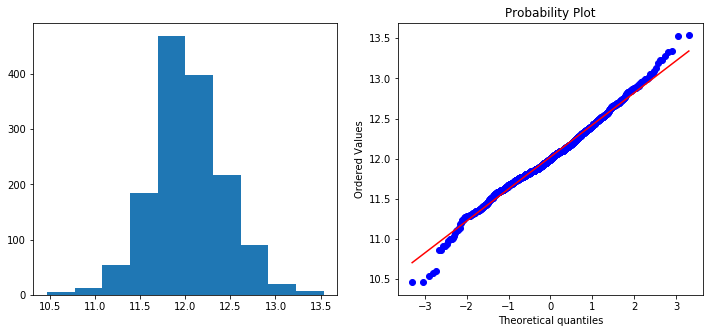

In [23]:
#Target Variable distribution

fig, (ax1, ax2) = plt.subplots(figsize=(12,5),ncols=2, sharey=False, )

#Q-Q plot
ax1.hist(train.SalePrice)
stats.probplot(train.SalePrice, plot = plt);

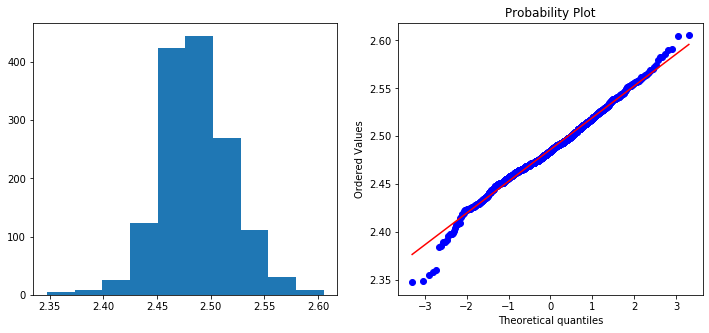

In [24]:
#Log transformed target variable

fig, (ax1, ax2) = plt.subplots(figsize=(12,5),ncols=2, sharey=False)

#Q-Q plot log transformed data

ax1.hist(np.log(train.SalePrice))
stats.probplot(np.log(train.SalePrice), plot = plt);

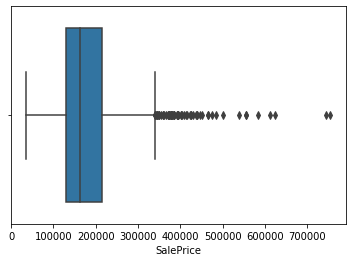

In [25]:
#Outlier detection using boxplot

s1 = sns.boxplot(df_train['SalePrice'], showfliers=True, )
plt.show()

# An Outlier Detection

In [26]:
#median is less than mean, distribution is positivly right skewed (1.88), Kurtosis indicates that we have
#outliers (6.54 > 3)
print("Skewenes: ", train.SalePrice.skew().round(2))
print("Kurtosis: ", train.SalePrice.kurt().round(2))
# We should consider log transformation for target variable

Skewenes:  0.13
Kurtosis:  0.81


In [27]:
#Outlier detection using z-score /whole dataset
def z_score_out_detect(data, target):
    q1 = np.percentile(data[target], 25)
    q3 = np.percentile(data[target], 75)
    iqr = q3 - q1
    print('Interquartile: ', iqr)
    upper = q3 + 1.5*iqr
    lower = q1-1.5*iqr
    print("Lower bound:",lower,"/", 'Upper bound:', upper)
    
    z_score = (data[target] - np.mean(data[target]))/ np.std(data[target])
    print((np.absolute(z_score)>2.5).sum())
    
z_score_out_detect(df_train, 'SalePrice') #whole dataset detecting about 40 rows to be outside lower/upper range   

Interquartile:  83975.0
Lower bound: 3937.5 / Upper bound: 339837.5
40


# Correlation

(38, 0)

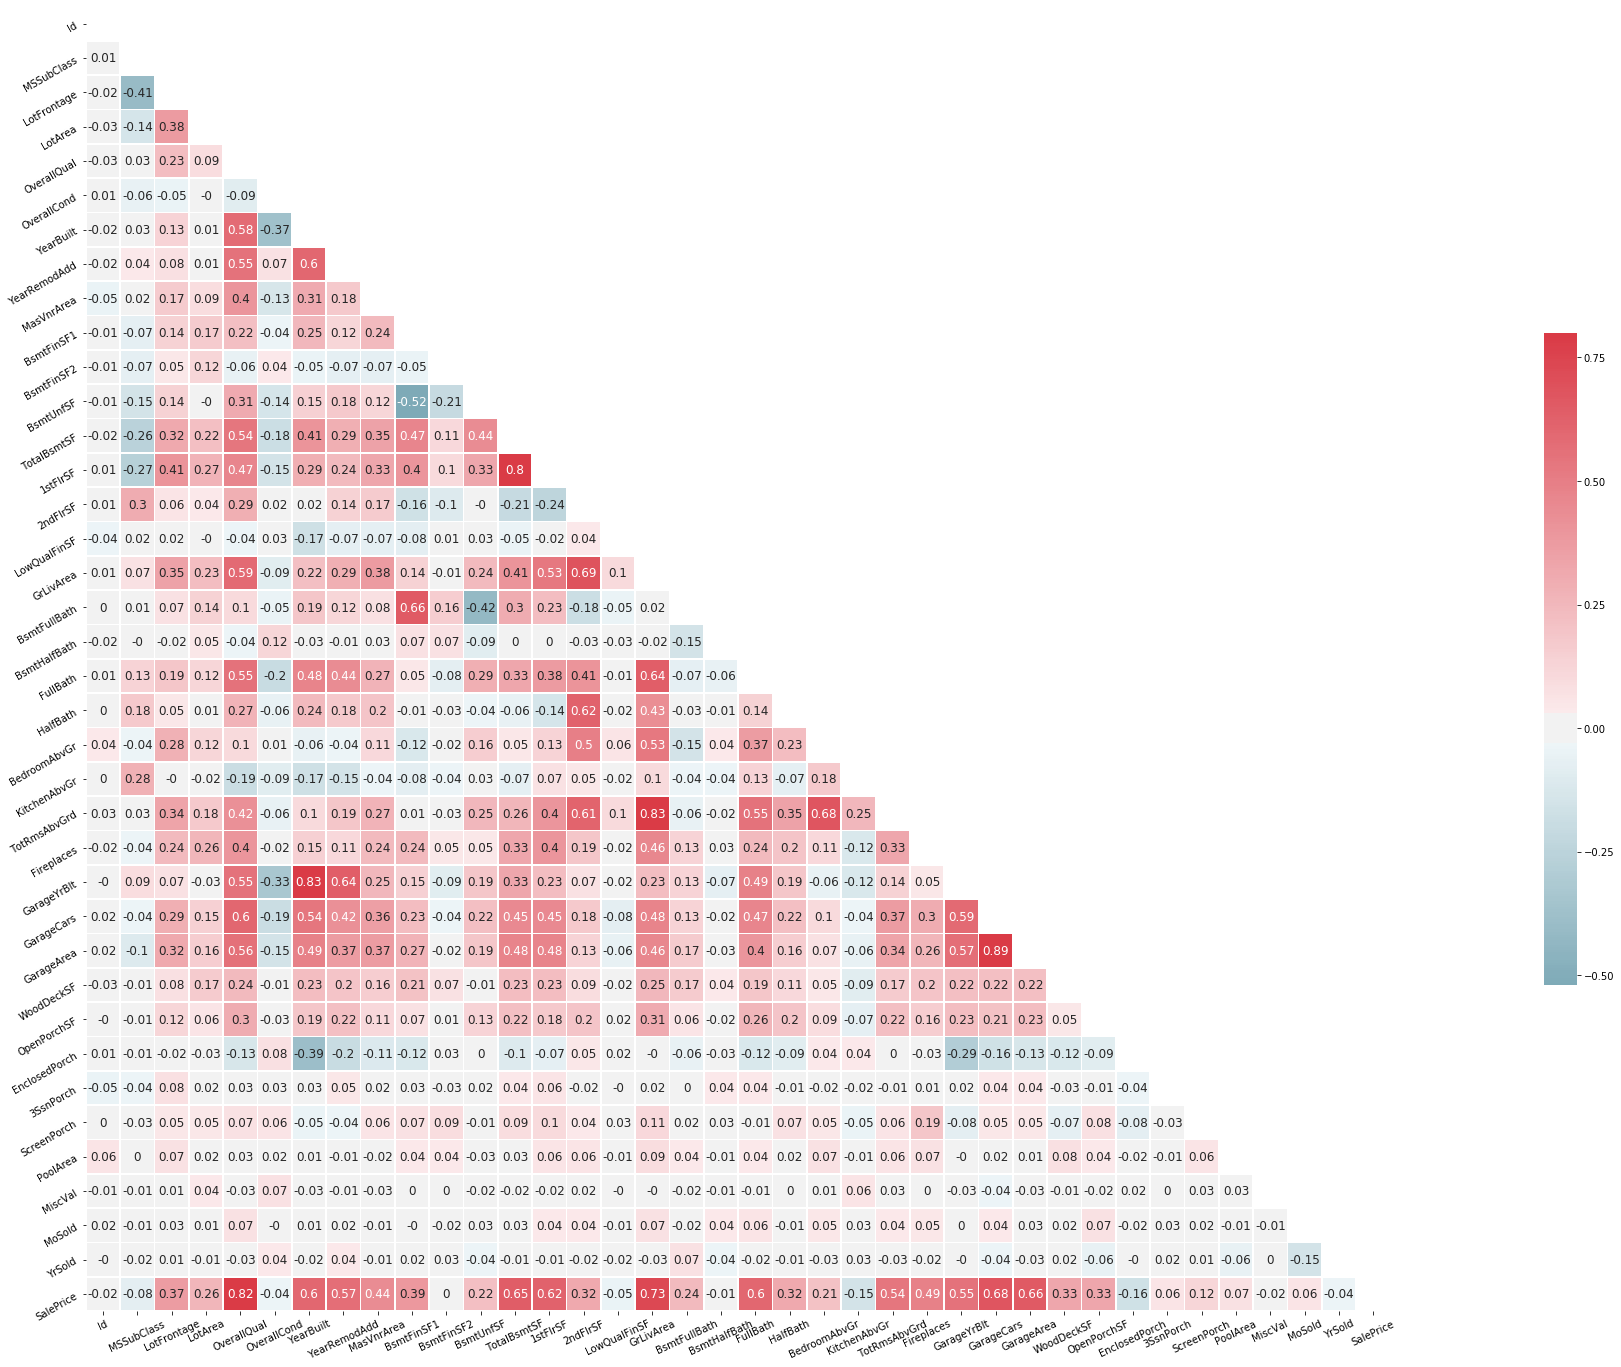

In [28]:
df_corr = train.copy()
corr_matrix = df_corr.corr().round(2)
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(55, 24))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 12})
plt.yticks(rotation=30); 
plt.xticks(rotation=25);
ax.get_ylim()
ax.set_ylim(38, 0)

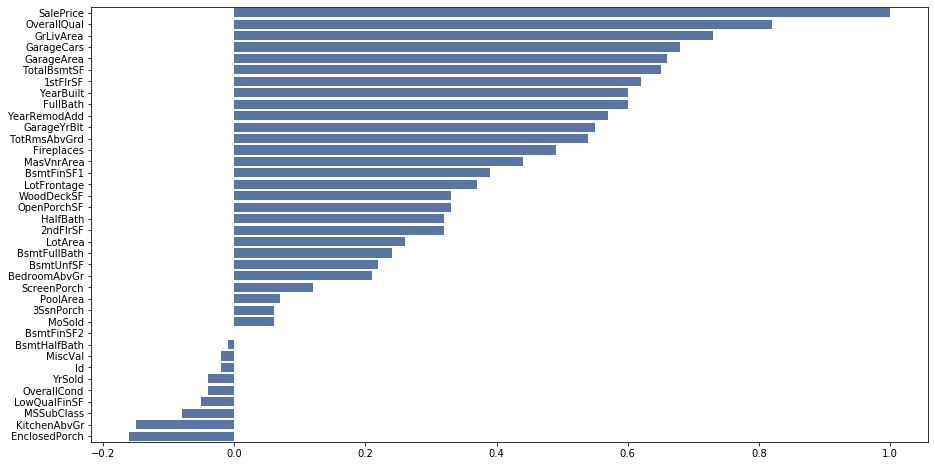

In [29]:
#Correlation - Sorted Features
corr_matrix = df_corr.corr().round(2)
sale_price_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
f, ax = plt.subplots(figsize=(15, 8))
sns.set_color_codes("deep")
sns.barplot(x = sale_price_corr.values, y = sale_price_corr.index, color='b');

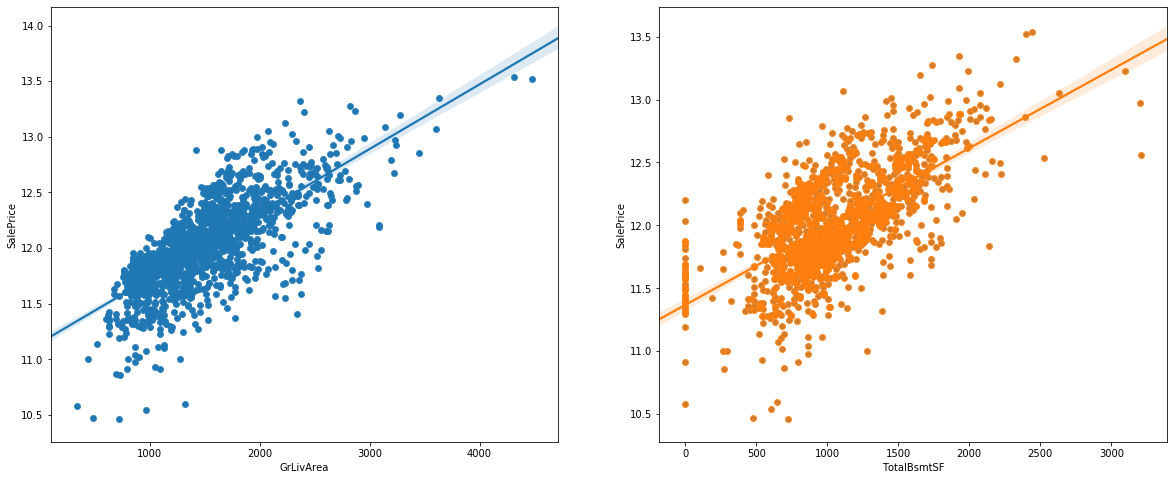

In [30]:
#Linearity for SalePrice featire with Two most correlated features

fig, (ax1, ax2) = plt.subplots(figsize=(20,8),ncols=2, sharey=False)

sns.scatterplot( x = train.GrLivArea, y = train.SalePrice,  ax=ax1)
sns.regplot(x=train.GrLivArea, y=train.SalePrice, ax=ax1)



sns.scatterplot( x = train['TotalBsmtSF'], y = train.SalePrice,  ax=ax2)
sns.regplot(x=train['TotalBsmtSF'], y=train.SalePrice, ax=ax2)

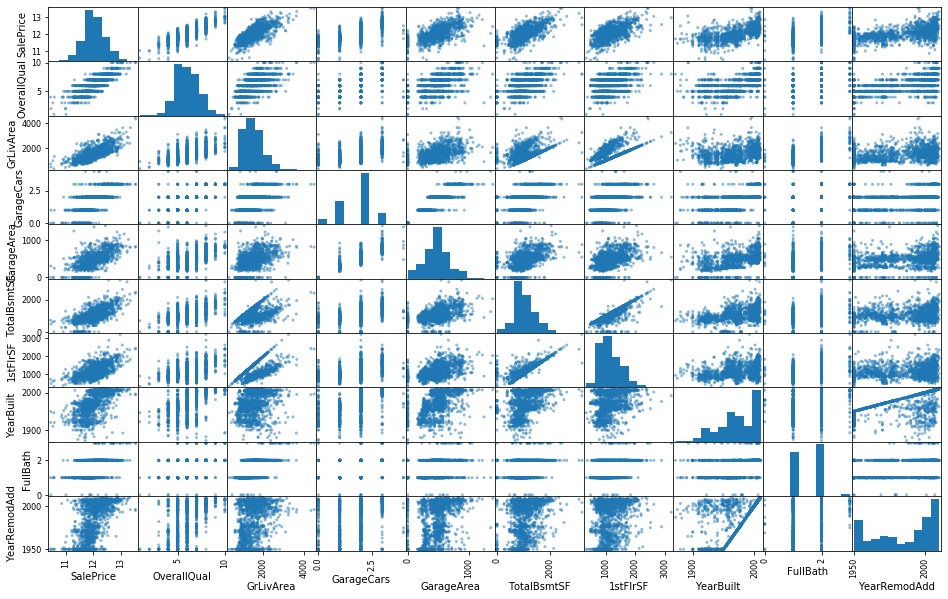

In [31]:
#Top 10 most correlated features with price

most_corr_features = sale_price_corr.index.tolist()

from pandas.plotting import scatter_matrix

scatter_matrix(train[most_corr_features[0:10]], figsize=(16,10));

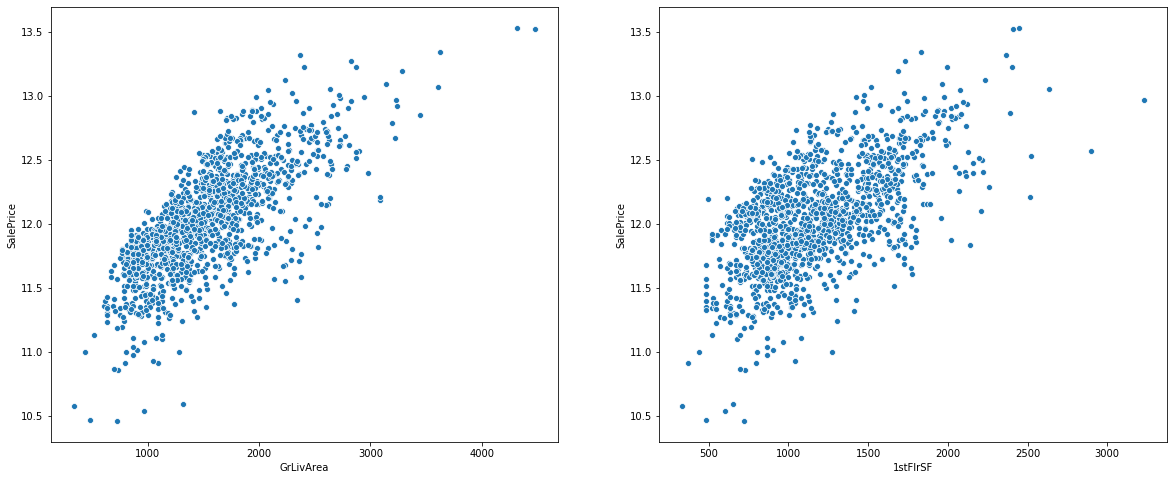

In [32]:
#SalePrice with Two most correlated features

fig, (ax1, ax2) = plt.subplots(figsize=(20,8),ncols=2, sharey=False)

sns.scatterplot( x = train.GrLivArea, y = train.SalePrice,  ax=ax1)
sns.scatterplot( x = train['1stFlrSF'], y = train.SalePrice,  ax=ax2)

# Data Preprocessing

In [33]:
#Adding new features and drop non informative

df = df.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

df['YrBltAndRemod']=df['YearBuilt']+df['YearRemodAdd']
df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df['Total_sqr_footage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +
                                 df['1stFlrSF'] + df['2ndFlrSF'])

df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [34]:

#COnvert categorical values using dummy
#final = pd.get_dummies(df).reset_index(drop=True)
#final.shape
final = df

In [35]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
#Fixing skewnes with numerical
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in df.columns:
    if df[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = df[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))

In [36]:
def nnous_sel(df):
    """This function dedect non informative features with more than 90 % zeros"""
    nn_cols = df.loc[:, (df.isin([' ','NULL',0]) | df.isnull()).mean() <= 0.9].columns.tolist()
    col_tdrop = set(df.columns.tolist()) - set(nn_cols)
    return df

In [37]:
X = final.iloc[:len(y), :]
X_test = final.iloc[len(y):, :]
X.shape, y.shape, X_test.shape

((1454, 87), (1454,), (1459, 87))

In [38]:
X = nnous_sel(X)

In [39]:
Z = pd.concat((X,y), axis = 1).reset_index(drop=True)
Z.shape

(1454, 88)

In [40]:
#Revert back train and test set
X = Z.drop('SalePrice', axis = 1)
y = Z['SalePrice']

In [41]:
X.shape, y.shape, X_test.shape

((1454, 87), (1454,), (1459, 87))

In [42]:
#Final Check for missing values in categorical
missing_numcat(X, categorical=True)

,values,NaN vals,(%) NaN


In [43]:
#Final Check for missing values in numerical
missing_numcat(X, categorical=False)

,values,NaN vals,(%) NaN


In [44]:
#Final Check shape
print(X.shape)

(1454, 87)


In [45]:


overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_test = X_test.drop(overfit, axis=1)

In [46]:
#Split  training dataset to train and test set
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=42)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.22, random_state=12)

for train_index, test_index in split.split(Z, Z['Neighborhood']):
    str_train = Z.iloc[train_index]
    str_test   = Z.iloc[test_index]
    

y_train = str_train['SalePrice']
y_ver  = str_test['SalePrice']
X_train = str_train.drop('SalePrice', axis = 1)
X_ver = str_test.drop('SalePrice', axis = 1)

In [47]:
X_train = nnous_sel(X_train)
X_ver = nnous_sel(X_ver)

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, Normalizer
from sklearn.impute import SimpleImputer


housing_num = X_train._get_numeric_data()
housing_cat = X_train.select_dtypes('object')

In [49]:
#Pipelines
num_pipeline = Pipeline([
    ('std_scal', RobustScaler(with_centering=True, with_scaling=True)),
])

cat_pipeline = Pipeline([
    ('one_hen', OneHotEncoder(handle_unknown='ignore')),
])

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
num_attrs = housing_num.columns.tolist()
cat_attrs = housing_cat.columns.tolist()
full_pipeline = ColumnTransformer([
    
    ('numerical_pl', num_pipeline, num_attrs),
    ('categorical_pl', cat_pipeline, cat_attrs ),
])

In [50]:
#Fit - Transform
X_train_prepared = full_pipeline.fit_transform(X_train)
X_ver_prepared = full_pipeline.transform(X_ver)
test_prepared = full_pipeline.transform(X_test)

# Modeling

# Ridge

In [51]:
from sklearn.linear_model import RidgeCV, Ridge
rdg = RidgeCV()
rdg.fit(X_train_prepared, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [52]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
def evaluate(X_train, y_train, X_test,y_test, clf):
    clf_predict_train = clf.predict(X_train)
    clf_predict_test = clf.predict(X_test)
    clfmse_train = mean_squared_error(np.expm1(y_train), np.expm1(clf_predict_train))**0.5
    clfmse_test = mean_squared_error(np.expm1(y_test), np.expm1(clf_predict_test))**0.5
    clfrmse_train = mean_squared_log_error(np.expm1(y_train), np.expm1(clf_predict_train))**0.5
    clfrmse_test = mean_squared_log_error(np.expm1(y_test), np.expm1(clf_predict_test))**0.5
    print("Evaluate---","***", "----")
    print("RMSE-train",clfmse_train)
    print("RMSE-test", clfmse_test)
    print("RMSLE-train", clfrmse_train)
    print("RMSLE-test", clfrmse_test)

In [53]:
#Ridge
evaluate(X_train_prepared, y_train, X_ver_prepared, y_ver,rdg)

Evaluate--- *** ----
RMSE-train 17307.26917661448
RMSE-test 18095.244492769958
RMSLE-train 0.09406065681804916
RMSLE-test 0.09775382193726684


# LASSO

In [54]:
from sklearn import linear_model
lso = linear_model.Lasso(max_iter=1e7, alpha=0.0008, random_state=12, tol=0.001, positive=True, warm_start=True)
lso.fit(X_train_prepared, y_train)

Lasso(alpha=0.0008, copy_X=True, fit_intercept=True, max_iter=10000000.0,
      normalize=False, positive=True, precompute=False, random_state=12,
      selection='cyclic', tol=0.001, warm_start=True)

In [55]:
#Lasso
evaluate(X_train_prepared, y_train, X_ver_prepared, y_ver,lso)

Evaluate--- *** ----
RMSE-train 19131.180996181476
RMSE-test 19211.48775299375
RMSLE-train 0.10548749873439522
RMSLE-test 0.09625521620665078


# ElasticNet

In [56]:
from sklearn.linear_model import ElasticNet

elnet = ElasticNet(alpha=0.001, max_iter=1e7, positive=True, l1_ratio=0.7)
elnet.fit(X_train_prepared, y_train)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.7,
           max_iter=10000000.0, normalize=False, positive=True,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [57]:
#ElasticNet
evaluate(X_train_prepared, y_train, X_ver_prepared, y_ver,elnet)

Evaluate--- *** ----
RMSE-train 18958.526116821693
RMSE-test 19053.545903460006
RMSLE-train 0.10488619963017405
RMSLE-test 0.09601739760313746


In [58]:
#Blending three best models 

In [59]:
rdg_predict = rdg.predict(test_prepared)
el_predict = elnet.predict(test_prepared)
lso_predict = lso.predict(test_prepared)

In [66]:
stacked = (0.1*rdg_predict + 0.1*lso_predict + 0.8*el_predict)

In [67]:
stacked

array([11.64557208, 11.99432764, 12.11126034, ..., 12.0431399 ,
       11.667932  , 12.33581833])

In [68]:
id_ = test['Id'].index.values
final_df= pd.DataFrame(data=zip(test['Id'].values,np.expm1(stacked)), columns=['Id', 'SalePrice'])
final_df.to_csv('zillow/sample_submission.csv', index=False, columns=['Id', 'SalePrice'])
pd.read_csv('zillow/sample_submission.csv')
final_df

,Id,SalePrice
0,1461,114183.641228
1,1462,161833.200959
2,1463,181907.726962
3,1464,205384.375682
4,1465,193778.327458
...,...,...
1454,2915,87482.660910
1455,2916,81224.715257
1456,2917,169928.665944
1457,2918,116765.559232
